<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Artificial Intelligence in Finance

## Neural Network Class

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## Activation Functions

In [1]:
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

In [2]:
def activation(x, act='linear', deriv=False):
    if act == 'sigmoid':
        if deriv:
            out = activation(x, 'sigmoid', False)
            return out * (1 - out)
        return 1 / (1 + np.exp(-x))
    elif act == 'relu':
        if deriv:
            return np.where(x > 0, 1, 0)
        return np.maximum(x, 0)
    elif act == 'softplus':
        if deriv:
            return activation(x, act='sigmoid')
        return np.log(1 + np.exp(x))
    elif act == 'linear':
        if deriv:
            return 1
        return x
    else:
        raise ValueError('Activation function not known.')

In [3]:
x = np.linspace(-1, 1, 20)

In [4]:
activation(x, 'sigmoid')

array([0.26894142, 0.29013328, 0.31228169, 0.33532221, 0.35917484,
       0.38374461, 0.40892261, 0.43458759, 0.46060812, 0.48684514,
       0.51315486, 0.53939188, 0.56541241, 0.59107739, 0.61625539,
       0.64082516, 0.66467779, 0.68771831, 0.70986672, 0.73105858])

In [5]:
activation(x, 'sigmoid', True)

array([0.19661193, 0.20595596, 0.21476184, 0.22288122, 0.23016827,
       0.23648468, 0.24170491, 0.24572122, 0.24844828, 0.24982695,
       0.24982695, 0.24844828, 0.24572122, 0.24170491, 0.23648468,
       0.23016827, 0.22288122, 0.21476184, 0.20595596, 0.19661193])

## Learning &mdash; Simple Neural Network

In [6]:
class sinn:
    def __init__(self, act='linear', lr=0.01, steps=100,
                 verbose=False, psteps=200):
        self.act = act
        self.lr = lr
        self.steps = steps
        self.verbose = verbose
        self.psteps = psteps
    def forward(self):
        ''' Forward propagation.
        '''
        self.l2 = activation(np.dot(self.l0, self.w), self.act)
    def backward(self):
        ''' Backwards propagation.
        '''
        self.e = self.l2 - self.y
        d = self.e * activation(self.l2, self.act, True)
        u = self.lr * np.dot(self.l0.T, d)
        self.w -= u
    def metrics(self, s):
        ''' Performance metrics.
        '''
        mse = (self.e ** 2).mean()
        acc = float(sum(self.l2.round() == self.y) / len(self.y))
        self.res = self.res.append(
            pd.DataFrame({'mse': mse, 'acc': acc}, index=[s,])
        )
        if s % self.psteps == 0 and self.verbose:
                print(f'step={s:5d} | mse={mse:.6f}')
                print(f'           | acc={acc:.6f}')
    def fit(self, l0, y, steps=None, seed=None):
        ''' Fitting step.
        '''
        self.l0 = l0
        self.y = y
        if steps is None:
            steps = self.steps
        self.res = pd.DataFrame()
        samples, features = l0.shape
        if seed is not None:
            np.random.seed(seed)
        self.w = np.random.random((features, 1))
        for s in range(1, steps + 1):
            self.forward()
            self.backward()
            self.metrics(s)
    def predict(self, X):
        ''' Prediction step.
        '''
        return activation(np.dot(X, self.w), self.act)

### Estimation

In [7]:
features = 5
samples = 5

In [8]:
np.random.seed(10)
l0 = np.random.standard_normal((samples, features))
l0

array([[ 1.3315865 ,  0.71527897, -1.54540029, -0.00838385,  0.62133597],
       [-0.72008556,  0.26551159,  0.10854853,  0.00429143, -0.17460021],
       [ 0.43302619,  1.20303737, -0.96506567,  1.02827408,  0.22863013],
       [ 0.44513761, -1.13660221,  0.13513688,  1.484537  , -1.07980489],
       [-1.97772828, -1.7433723 ,  0.26607016,  2.38496733,  1.12369125]])

In [9]:
np.linalg.matrix_rank(l0)

5

In [10]:
y = np.random.random((samples, 1))
y

array([[0.8052232 ],
       [0.52164715],
       [0.90864888],
       [0.31923609],
       [0.09045935]])

In [11]:
reg = np.linalg.lstsq(l0, y, rcond=-1)[0]

In [12]:
reg

array([[-0.74919308],
       [ 0.00146473],
       [-1.49864704],
       [-0.02498757],
       [-0.82793882]])

In [13]:
np.allclose(np.dot(l0, reg), y)

True

In [14]:
model = sinn(lr=0.015, act='linear', steps=6000,
            verbose=True, psteps=1000)

In [15]:
%time model.fit(l0, y, seed=100)

step= 1000 | mse=0.008086
           | acc=0.000000
step= 2000 | mse=0.000545
           | acc=0.000000
step= 3000 | mse=0.000037
           | acc=0.000000
step= 4000 | mse=0.000002
           | acc=0.000000
step= 5000 | mse=0.000000
           | acc=0.000000
step= 6000 | mse=0.000000
           | acc=0.000000
CPU times: user 5.23 s, sys: 29.7 ms, total: 5.26 s
Wall time: 5.26 s


In [16]:
model.predict(l0)

array([[0.80512489],
       [0.52144986],
       [0.90872498],
       [0.31919803],
       [0.09045743]])

In [17]:
model.predict(l0) - y

array([[-0.0000983 ],
       [-0.00019729],
       [ 0.0000761 ],
       [-0.00003806],
       [-0.00000191]])

### Classification

In [18]:
features = 5
samples = 10

In [19]:
np.random.seed(3)
l0 = np.random.randint(0, 2, (samples, features))
l0

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 1, 1, 1]])

In [20]:
np.linalg.matrix_rank(l0)

5

In [21]:
y = np.random.randint(0, 2, (samples, 1))
y

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [22]:
model = sinn(lr=0.01, act='sigmoid')

In [23]:
%time model.fit(l0, y, 4000)

CPU times: user 3.57 s, sys: 9.6 ms, total: 3.58 s
Wall time: 3.59 s


In [24]:
model.l2

array([[0.51118415],
       [0.34390898],
       [0.84733758],
       [0.07601979],
       [0.40505454],
       [0.84145926],
       [0.95592461],
       [0.72680243],
       [0.11219587],
       [0.00806003]])

In [25]:
model.predict(l0).round() == y

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

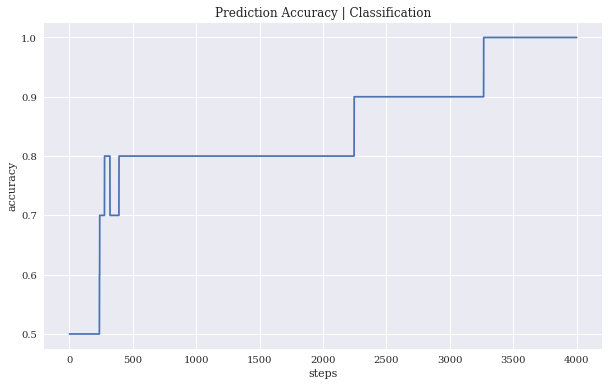

In [26]:
ax = model.res['acc'].plot(figsize=(10, 6),
            title='Prediction Accuracy | Classification')
ax.set(xlabel='steps', ylabel='accuracy');
# plt.savefig('../../images/ch16/figure_nnc_01.png');

## Learning &mdash; One Hidden Layer

Shallow neural network = ONE hidden layer = not DEEP neural network.

In [27]:
class shnn:
    def __init__(self, units=12, act='linear', lr=0.01, steps=100,
                 verbose=False, psteps=200, seed=None):
        self.units = units
        self.act = act
        self.lr = lr
        self.steps = steps
        self.verbose = verbose
        self.psteps = psteps
        self.seed = seed
    def initialize(self):
        ''' Initializes the random weights.
        '''
        if self.seed is not None:
            np.random.seed(self.seed)
        samples, features = self.l0.shape
        self.w0 = np.random.random((features, self.units))
        self.w1 = np.random.random((self.units, 1))
    def forward(self):
        ''' Forward propagation.
        '''
        self.l1 = activation(np.dot(self.l0, self.w0), self.act)
        self.l2 = activation(np.dot(self.l1, self.w1), self.act)
    def backward(self):
        ''' Backward propagation.
        '''
        self.e = self.l2 - self.y
        d2 = self.e * activation(self.l2, self.act, True)
        u2 = self.lr * np.dot(self.l1.T, d2)
        self.w1 -= u2
        e1 = np.dot(d2, self.w1.T)
        d1 = e1 * activation(self.l1, self.act, True)
        u1 = self.lr * np.dot(self.l0.T, d1)
        self.w0 -= u1
    def metrics(self, s):
        ''' Performance metrics.
        '''
        mse = (self.e ** 2).mean()
        acc = float(sum(self.l2.round() == self.y) / len(self.y))
        self.res = self.res.append(
            pd.DataFrame({'mse': mse, 'acc': acc}, index=[s,])
        )
        if s % self.psteps == 0 and self.verbose:
                print(f'step={s:5d} | mse={mse:.5f}')
                print(f'           | acc={acc:.5f}')
    def fit(self, l0, y, steps=None):
        ''' Fitting step.
        '''
        self.l0 = l0
        self.y = y
        if steps is None:
            steps = self.steps
        self.res = pd.DataFrame()
        self.initialize()
        self.forward()
        for s in range(1, steps + 1):
            self.backward()
            self.forward()
            self.metrics(s)
    def predict(self, X):
        ''' Prediction step.
        '''
        l1 = activation(np.dot(X, self.w0), self.act)
        l2 = activation(np.dot(l1, self.w1), self.act)
        return l2

### Estimation

In [28]:
features = 5
samples = 10

In [29]:
l0 = np.random.standard_normal((samples, features))

In [30]:
np.linalg.matrix_rank(l0)

5

In [31]:
y = np.random.random((samples, 1))

In [32]:
reg = np.linalg.lstsq(l0, y, rcond=-1)[0]

In [33]:
(np.dot(l0, reg)  - y)

array([[-0.10226341],
       [-0.42357164],
       [-0.25150491],
       [-0.30984143],
       [-0.85213261],
       [-0.13791373],
       [-0.52336502],
       [-0.50304204],
       [-0.7728686 ],
       [-0.3716898 ]])

In [34]:
((np.dot(l0, reg)  - y) ** 2).mean()

0.23567187607888118

In [35]:
model = shnn(lr=0.01, units=16, act='softplus',
             verbose=True, psteps=2000, seed=100)

In [36]:
%time model.fit(l0, y, 8000)

step= 2000 | mse=0.00205
           | acc=0.00000
step= 4000 | mse=0.00098
           | acc=0.00000
step= 6000 | mse=0.00043
           | acc=0.00000
step= 8000 | mse=0.00022
           | acc=0.00000
CPU times: user 8.15 s, sys: 69.2 ms, total: 8.22 s
Wall time: 8.3 s


In [37]:
model.l2 - y

array([[-0.00390976],
       [-0.00522077],
       [ 0.02053932],
       [-0.0042113 ],
       [-0.0006624 ],
       [-0.01001395],
       [ 0.01783203],
       [-0.01498316],
       [-0.0177866 ],
       [ 0.02782519]])

### Classification

In [38]:
model = shnn(lr=0.025, act='sigmoid', steps=200,
             verbose=True, psteps=50, seed=100)

In [39]:
l0.round()

array([[ 0., -1., -2.,  1., -0.],
       [-1., -2., -0., -0., -2.],
       [ 0.,  1., -1., -1., -1.],
       [-0.,  0., -1., -0., -1.],
       [ 1., -1.,  1.,  1., -1.],
       [ 1., -1.,  1., -2.,  1.],
       [-1., -0.,  1., -1.,  1.],
       [ 1.,  2., -1., -0., -0.],
       [-1.,  0.,  0.,  0.,  2.],
       [ 0.,  0., -0.,  1.,  1.]])

In [40]:
np.linalg.matrix_rank(l0)

5

In [41]:
y.round()

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [42]:
model.fit(l0.round(), y.round())

step=   50 | mse=0.26774
           | acc=0.60000
step=  100 | mse=0.22556
           | acc=0.60000
step=  150 | mse=0.19939
           | acc=0.70000
step=  200 | mse=0.16924
           | acc=1.00000


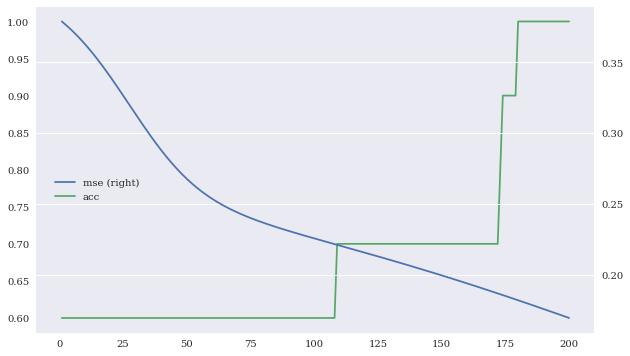

In [43]:
ax = model.res.plot(figsize=(10, 6), secondary_y='mse')
ax.get_legend().set_bbox_to_anchor((0.2, 0.5));
# plt.savefig('../../images/ch16/figure_nnc_02.png');

## Financial Data

In [44]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [45]:
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

In [46]:
sym = 'EUR='

In [47]:
data = pd.DataFrame(raw[sym])

In [48]:
lags = 5
cols = []
data['r'] = np.log(data / data.shift(1))
data['d'] = np.where(data['r'] > 0, 1, 0)
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['r'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)
data[cols] = (data[cols] - data[cols].mean()) / data[cols].std()

In [49]:
data.head()

,EUR=,r,d,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-12,1.4494,-0.001310,0,1.256582,1.177935,-1.142025,0.560551,-0.511372
2010-01-13,1.4510,0.001103,1,-0.214533,1.255944,1.178974,-1.142118,0.560740
2010-01-14,1.4502,-0.000551,0,0.213539,-0.214803,1.256989,1.178748,-1.141841
2010-01-15,1.4382,-0.008309,0,-0.079986,0.213163,-0.213853,1.256758,1.178904
2010-01-19,1.4298,-0.005858,0,-1.456028,-0.080289,0.214140,-0.214000,1.256910


In [50]:
model = shnn(lr=0.0001, act='sigmoid', steps=10000,
             verbose=True, psteps=2000, seed=100)

In [51]:
y = data['d'].values.reshape(-1, 1)

In [52]:
%time model.fit(data[cols].values, y)

step= 2000 | mse=0.24964
           | acc=0.51594
step= 4000 | mse=0.24951
           | acc=0.52390
step= 6000 | mse=0.24945
           | acc=0.52231
step= 8000 | mse=0.24940
           | acc=0.52510
step=10000 | mse=0.24936
           | acc=0.52430
CPU times: user 9min 1s, sys: 40.9 s, total: 9min 42s
Wall time: 1min 21s


In [53]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, -1)

In [54]:
data['p'].value_counts()

 1    1257
-1    1253
Name: p, dtype: int64

In [55]:
data['s'] = data['p'] * data['r']

In [56]:
data[['r', 's']].sum().apply(np.exp)

r    0.772411
s    1.885677
dtype: float64

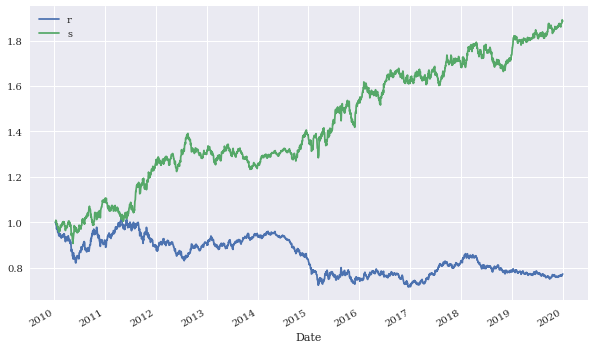

In [57]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch16/figure_nnc_03.png');

## Improved Optimizer

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">